# Predict False Positives to Reduce Alert Triage 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [7]:
import pandas as pd
# In Kaggle, the path is always this:
train_data = pd.read_csv('../input/microsoft-security-incident-prediction/GUIDE_Train.csv', nrows=10000)
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [8]:
test_data = pd.read_csv('../input/microsoft-security-incident-prediction/GUIDE_Test.csv', nrows=10000)

In [9]:
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [10]:
train_data['Category'].unique()

array(['InitialAccess', 'Exfiltration', 'CommandAndControl', 'Execution',
       'SuspiciousActivity', 'Impact', 'Collection', 'CredentialAccess',
       'Persistence', 'Discovery', 'Malware', 'DefenseEvasion', 'Exploit',
       'PrivilegeEscalation', 'LateralMovement', 'Ransomware',
       'UnwantedSoftware'], dtype=object)

In [11]:
train_data['IncidentGrade'].unique()

array(['TruePositive', 'FalsePositive', 'BenignPositive', nan],
      dtype=object)

In [12]:
train_data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    4391
TruePositive      3446
FalsePositive     2110
Name: count, dtype: int64

In [13]:
# Percentage count summary of Incident Grade classes
Grade_Ratio=train_data['IncidentGrade'].value_counts() * 100 / train_data['IncidentGrade'].shape[0]
print (Grade_Ratio)

IncidentGrade
BenignPositive    43.91
TruePositive      34.46
FalsePositive     21.10
Name: count, dtype: float64


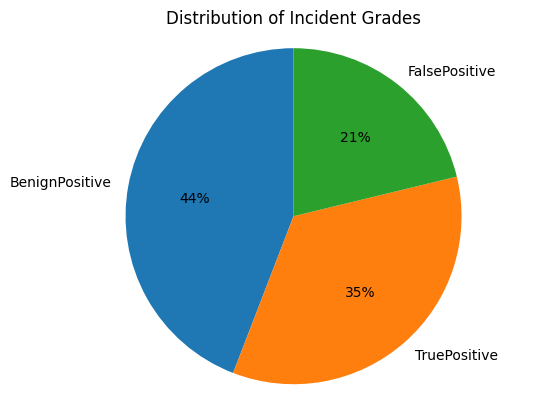

In [14]:
plt.pie(Grade_Ratio, labels = Grade_Ratio.index, autopct='%1.0f%%', startangle=90) # use index for label bec grade ratio is a series
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Incident Grades')
plt.show()

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int64  
 1   OrgId               10000 non-null  int64  
 2   IncidentId          10000 non-null  int64  
 3   AlertId             10000 non-null  int64  
 4   Timestamp           10000 non-null  object 
 5   DetectorId          10000 non-null  int64  
 6   AlertTitle          10000 non-null  int64  
 7   Category            10000 non-null  object 
 8   MitreTechniques     4201 non-null   object 
 9   IncidentGrade       9947 non-null   object 
 10  ActionGrouped       59 non-null     object 
 11  ActionGranular      59 non-null     object 
 12  EntityType          10000 non-null  object 
 13  EvidenceRole        10000 non-null  object 
 14  DeviceId            10000 non-null  int64  
 15  Sha256              10000 non-null  int64  
 16  IpAdd

In [16]:
train_data.isnull().sum()

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques       5799
IncidentGrade           53
ActionGrouped         9941
ActionGranular        9941
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
DeviceName               0
NetworkMessageId         0
EmailClusterId        9881
RegistryKey              0
RegistryValueName        0
RegistryValueData        0
ApplicationId            0
ApplicationName          0
OAuthApplicationId       0
ThreatFamily          9923
FileName                 0
FolderPath               0
ResourceIdName           0
ResourceType          9992
Roles                 9789
O

## Feature Selection

### TimeStamp

In [17]:
# Parse Timestamp to datetime
# Handles strings like: 2024-06-04T22:56:27.000Z
train_data["Timestamp"] = pd.to_datetime(train_data["Timestamp"], errors="coerce")

# Derive simple, leakage-safe time features
train_data["hour"] = train_data["Timestamp"].dt.hour.fillna(-1).astype(int)
train_data["dow"] = train_data["Timestamp"].dt.dayofweek.fillna(-1).astype(int)  # 0=Mon
train_data["is_weekend"] = train_data["dow"].isin([5,6]).astype(int)

In [18]:
train_data['Timestamp'].unique()

<DatetimeArray>
['2024-06-04 06:05:15+00:00', '2024-06-14 03:01:25+00:00',
 '2024-06-13 04:52:55+00:00', '2024-06-10 16:39:36+00:00',
 '2024-06-15 01:08:07+00:00', '2024-06-10 13:30:56+00:00',
 '2024-06-14 23:19:45+00:00', '2024-06-06 13:39:23+00:00',
 '2024-06-09 10:21:29+00:00', '2024-06-08 02:08:01+00:00',
 ...
 '2024-06-05 02:18:21+00:00', '2024-06-10 08:33:51+00:00',
 '2024-06-04 08:51:01+00:00', '2024-06-11 09:21:57+00:00',
 '2024-05-30 22:29:04+00:00', '2024-06-11 16:43:21+00:00',
 '2024-06-07 06:51:11+00:00', '2024-06-07 23:48:32+00:00',
 '2024-06-05 18:43:59+00:00', '2024-06-15 12:11:19+00:00']
Length: 9580, dtype: datetime64[ns, UTC]

In [19]:
# List to store columns with more than 40% null values, these shoul be dropped as they are too significantly empty
columns_with_high_null = []

total_rows = len(train_data) 

for column in train_data.columns:
    
    if train_data[column].isnull().sum() / total_rows > 0.4:
        columns_with_high_null.append(column)

print("Columns with more than 40% null values:", columns_with_high_null)

Columns with more than 40% null values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [20]:
# Based on 40% threshold discovery:
cols_to_drop = [
    'MitreTechniques', 'ActionGrouped', 'ActionGranular', 
    'EmailClusterId', 'ThreatFamily', 'ResourceType', 
    'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict'
]

# Add ID columns (they have no predictive power)
ids_to_drop = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'Detectorid']

# Combine and drop
final_drop_list = cols_to_drop + ids_to_drop
clean_train_data = train_data.drop(columns=final_drop_list, errors='ignore')

# IMPORTANT: Drop the 53 rows where IncidentGrade is NaN
clean_train_data = clean_train_data.dropna(subset=['IncidentGrade'])

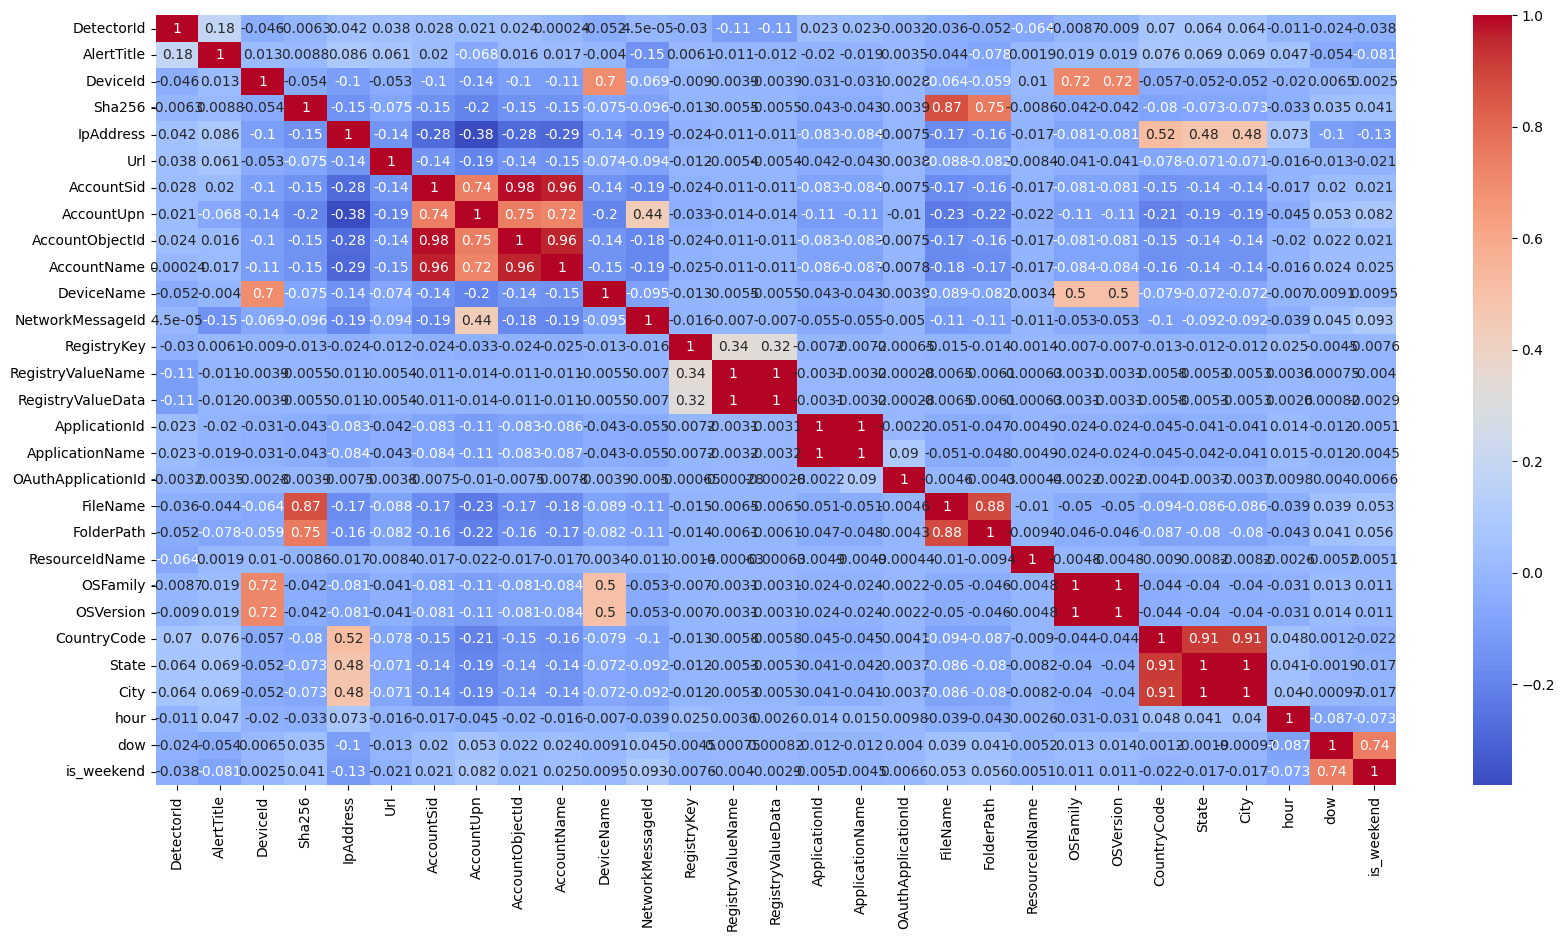

In [21]:
plt.figure(figsize=(20, 10))
# numeric_only
sns.heatmap(clean_train_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

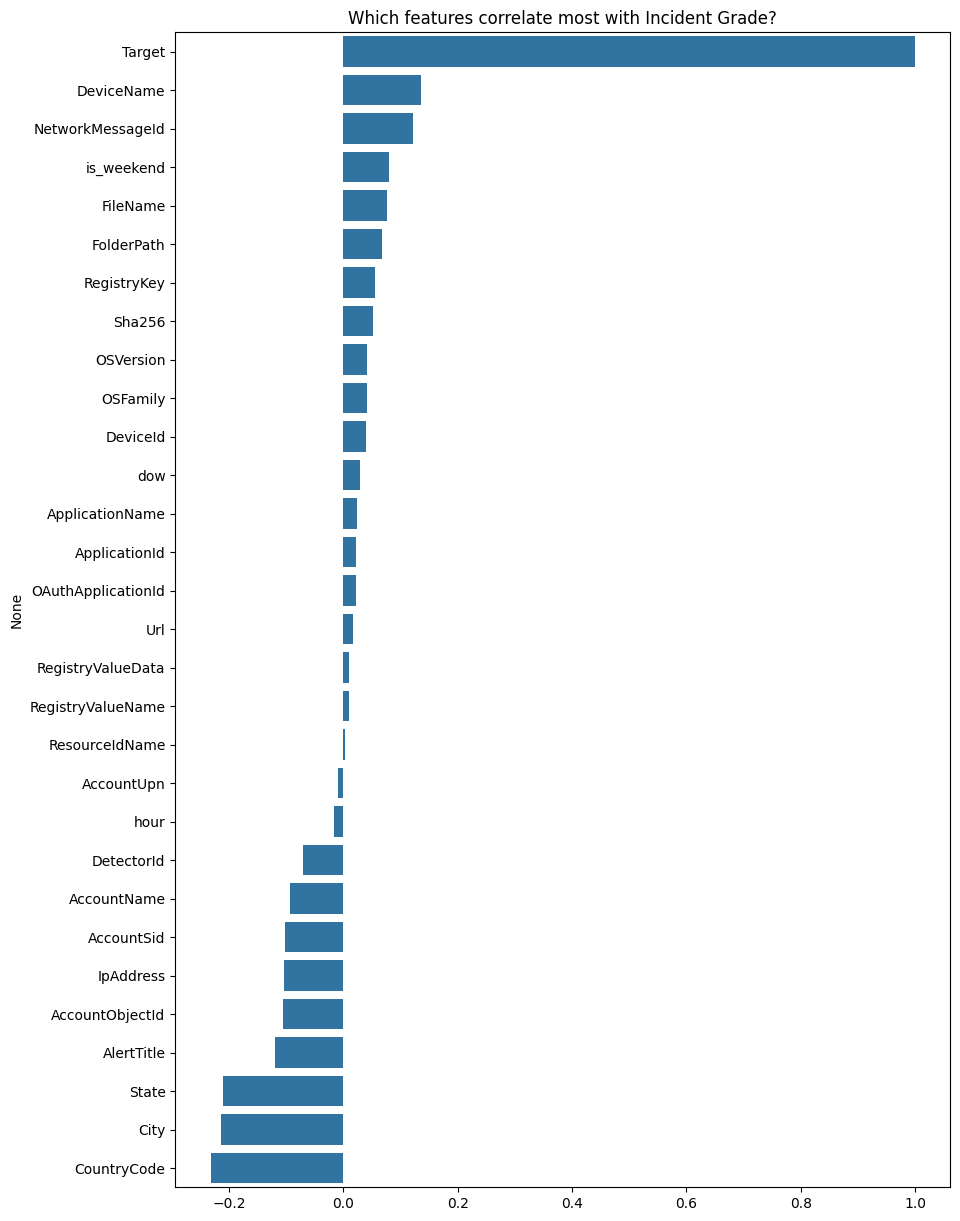

In [22]:
# Create a numeric version of the target in the clean dataframe
mapping = {'FalsePositive': 0, 'BenignPositive': 1, 'TruePositive': 2}
clean_train_data['Target'] = clean_train_data['IncidentGrade'].map(mapping)

# Now check correlation again, specifically looking at the 'Target' column
plt.figure(figsize=(10, 15))
correlations = clean_train_data.corr(numeric_only=True)['Target'].sort_values(ascending=False)
sns.barplot(x=correlations.values, y=correlations.index)
plt.title("Which features correlate most with Incident Grade?")
plt.show()

# Data Validation & Split

In [23]:
# 1. Prepare the TEST data to match clean_train_data
# (Dropping the same columns and mapping the grade)
test_mapping = {'FalsePositive': 0, 'BenignPositive': 1, 'TruePositive': 2}

# Applying logic to the test file
clean_test_data = test_data.drop(columns=final_drop_list, errors='ignore').dropna(subset=['IncidentGrade'])
clean_test_data['Target'] = clean_test_data['IncidentGrade'].map(test_mapping)

#Define X (Features) and y (Target)
X_train_full = clean_train_data.select_dtypes(include=[np.number]).drop(columns=['Target'], errors='ignore')
y_train_full = clean_train_data['Target']

X_test_final = clean_test_data.select_dtypes(include=[np.number]).drop(columns=['Target'], errors='ignore')
y_test_final = clean_test_data['Target']

# 3. Create the Validation Split from training data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"X_train is ready with {X_train.shape[1]} features.")

X_train is ready with 29 features.


# Model Selection

To select the most suitable model for this classification problem, I will measure the performance of each of the following 3 classification algorithms: 
1. Logistic Regression
2. Random Forest
3. XGBoost

In order to select the best perfoming model statistically.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

# The models to be tested
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, objective="multi:softmax", num_class=3)
}

# The parameters found earlier
param_grids = {
    "Logistic Regression": {"C": [0.1, 1.0, 10.0]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [10, 15]},
    "XGBoost": {"learning_rate": [0.1, 0.3], "n_estimators": [100]}
}

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=kf, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best version of {name} found.")

# Find which one did best on validation data
highest_scoring = max(best_models, key=lambda k: accuracy_score(y_val, best_models[k].predict(X_val)))
best_model = best_models[highest_scoring]

print(f"\nBest Performer: {highest_scoring}")

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best version of Logistic Regression found.
Training Random Forest...
Best version of Random Forest found.
Training XGBoost...
Best version of XGBoost found.

Best Performer: XGBoost


# Model Evaluation

--- FINAL EVALUATION ON TEST DATA ---
                precision    recall  f1-score   support

 FalsePositive       0.75      0.52      0.61      2167
BenignPositive       0.71      0.90      0.79      4192
  TruePositive       0.82      0.71      0.76      3641

      accuracy                           0.75     10000
     macro avg       0.76      0.71      0.72     10000
  weighted avg       0.76      0.75      0.74     10000



<Figure size 800x600 with 0 Axes>

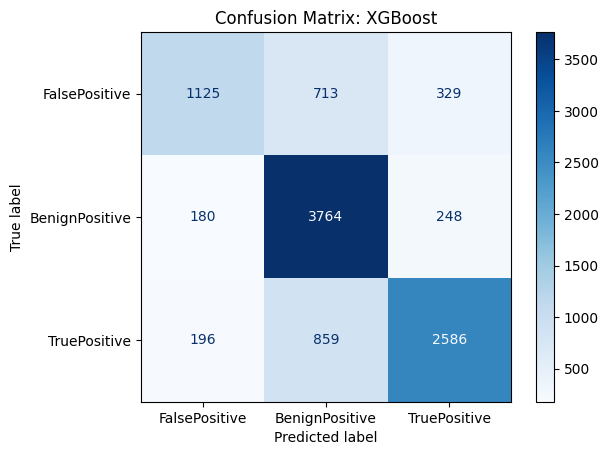

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Predict using XGBoost
y_pred = best_model.predict(X_test_final)

# 2. Print the detailed report
print("--- FINAL EVALUATION ON TEST DATA ---")
print(classification_report(y_test_final, y_pred, target_names=['FalsePositive', 'BenignPositive', 'TruePositive']))

# 3. Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_final, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FalsePositive', 'BenignPositive', 'TruePositive'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix: {highest_scoring}')
plt.show()